# Metrics Computation YOLOv5

In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score
import cv2
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import yaml
import shutil
import seaborn as sns

In [2]:
names = ['Nike', 'Adidas', 'Puma', 'Starbucks', 'The North Face', 'Under Armour', 'Apple Inc-', 'Mercedes-Benz', 'NFL', 'Coca-Cola', 'Hard Rock Cafe']
dict_names = {str(i):names[i] for i in range(len(names))}

In [3]:
def convert(x):
    """
    From x_min, y_min, width and height to normal coordinates
    """
    x_min = int((float(x[1])-(float(x[3])/2))*640)
    x_max = int((float(x[1])+(float(x[3])/2))*640)

    y_min = int((float(x[2])-(float(x[4])/2))*640)
    y_max = int((float(x[2])+(float(x[4])/2))*640)
    return x_min, x_max, y_min, y_max


def list_to_coord(x):
    """
    Create rectangular corners coordinates
    """
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    
    x = [[x0, x2], [x1, x2], [x1, x3], [x0, x3]]
    return x

def calculate_iou(box_1, box_2):
    """
    Compute IoU, given two box of coordinates
    """
    box_1 = list_to_coord(box_1)
    box_2 = list_to_coord(box_2)
    
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou


def overwrite(path, x_y_true, x_y_pred):
    """
    Boxes on images, green is the truth, red is prediction
    """
    image = cv2.imread(path)
    start_point_true, end_point_true = (x_y_true[0], x_y_true[3]), (x_y_true[1], x_y_true[2])
    start_point_pred, end_point_pred = (x_y_pred[0], x_y_pred[3]), (x_y_pred[1], x_y_pred[2])

    color_true = (0, 255, 0) #green
    color_pred = (255, 0, 0) #red

    thickness = 3


    image = cv2.rectangle(image, start_point_true, end_point_true, color_true, thickness)
    image = cv2.rectangle(image, start_point_pred, end_point_pred, color_pred, thickness)

    # Window name in which image is displayed
    plt.imshow(image)
    plt.show()
    
    
def generating_IoU(path_true_label, path_pred, path_image, print_image=False, print_image_IoU=0.001, choosing_pic='No'):
    """
    IoU computation for all images
    """
    file_type = 'txt'
    name_files = []
    data = []
    c = 0
    list_conf = []

    for file in glob.iglob(path_true_label+'*.'+file_type):
        name_file = file.split("/")[-1].split('.'+file_type)[0]
        name_files.append(name_file)

    for item in name_files:
        with open(path_true_label+item+'.txt') as f:
            true = f.readlines()
            if len(true)!=0:
                true = true[0].split()
                try:
                    with open(path_pred+item+'.txt') as g:
                        preds = g.readlines()
                        if len(preds)>1:
                            all_iou = []
                            all_conf = []

                            x_y_true = np.array(convert(true))
                            for i in range(len(preds)):
                                x_y_pred = np.array(convert(preds[i].split()))
                                all_iou.append(calculate_iou(x_y_true, x_y_pred))
                                all_conf.append(float(preds[i].split()[-1]))

                            if choosing_pic=='iou':
                                max_value = all_iou.index(max(all_iou))
                            if choosing_pic=='conf':
                                max_value = all_conf.index(max(all_conf))

                            pred = preds[max_value].split()
                        else:
                            pred = preds[0].split()
            
                        a = []
                        a.append(true[0])
                        a.append(pred[0])

                        x_y_true = np.array(convert(true))
                        x_y_pred = np.array(convert(pred))

                        IoU = calculate_iou(x_y_true, x_y_pred)
                        a.append(IoU)   
                            
                        if print_image==True:
                            if IoU == 0 and true[0] == '0':
                                list_conf.append(pred[-1])
                                c+=1
                                print("True label")
                                with open(path_true_label+item+'.txt') as true_txt:
                                    print(true_txt.readlines())

                                print("Predicted label")
                                with open(path_pred+item+'.txt') as prediction_txt:
                                    print(prediction_txt.readlines())

                                print(IoU)
                                print(f"x_y_true: {x_y_true}")
                                print(f"x_y_pred: {x_y_pred}")

                                overwrite(path_image+item+'.jpg', x_y_true, x_y_pred)
                                
                except:
                    a = [true[0], -1, 0]
                        
                data.append(a)
    return data

In [4]:
def boxplot_confidence(path_true_label, path_pred, path_image):
    """
    Compute dataset with all predictions
    """
    file_type = 'txt'
    name_files = []
    
    data = []
    
    for file in glob.iglob(path_true_label+'*.'+file_type):
        name_file = file.split("/")[-1].split('.'+file_type)[0]
        name_files.append(name_file)

    for item in name_files:
        with open(path_true_label+item+'.txt') as f:
            true = f.readlines()
            if len(true) != 0:
                true = true[0].split()
                try:
                    with open(path_pred+item+'.txt') as g:
                        preds = g.readlines()
                        if len(preds) > 1:
                            x_y_true = np.array(convert(true))
                            for i in range(len(preds)):
                                
                                x_y_pred = convert(preds[i].split())
                                iou_pred = calculate_iou(x_y_true, np.array(x_y_pred))
                                
                                true_label = true[0]
                                pred_label = preds[i].split()[0]
                                _conf = float(preds[i].split()[-1])
                                true_bounding = convert(true)
                                
                                new_row = item, true_label, pred_label, iou_pred, _conf, true_bounding, x_y_pred
                                data.append(new_row)

                        else:
                            x_y_true = np.array(convert(true))
                            x_y_pred = convert(preds[0].split())
                            
                            iou_pred = calculate_iou(x_y_true, np.array(x_y_pred))
      
                            true_label = true[0]
                            pred_label = preds[0].split()[0]
                            _conf = float(preds[0].split()[-1])
                            true_bounding = convert(true)
                            
                            new_row = item, true_label, pred_label, iou_pred, _conf, true_bounding, x_y_pred
                            data.append(new_row)

                except:
                    
                    true_label = true[0]                 
                    
                    new_row = item, true_label, -1, 0, 0, np.zeros(4), np.zeros(4)
                    data.append(new_row)
    
    data = pd.DataFrame(data, columns= ['picture','true_label','pred_label','list_iou','list_conf','true_bounding','pred_bounding'])
    
    return data

# Predictions on Test SET

In [5]:
with open(r'/home/3054408/yolov5/data/data.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    dic_data = yaml.load(file, Loader=yaml.FullLoader)
    name_list = dic_data['names']
    
name_data = pd.DataFrame(name_list).reset_index().rename(columns={'index':'true_cat'})

exp = 'exp10'

path_image = "/home/3054408/yolov5/runs/detect/"+exp+"/"
path_true_label = "/home/3054408/new_data/final_test/labels/"
path_pred = "/home/3054408/yolov5/runs/detect/"+exp+"/labels/"

data = generating_IoU(path_true_label, path_pred, path_image, print_image=False, choosing_pic='iou')
data = pd.DataFrame(data).rename(columns={0: "true_cat", 1: "pred_cat", 2: "IoU"})
data['true_cat'] = data['true_cat'].astype('int64')
data['pred_cat'] = data['pred_cat'].astype('int64')
data = data.merge(name_data, on="true_cat").rename(columns={0:"true_name"})

In [6]:
test = boxplot_confidence(path_true_label, path_pred, path_image)

In [7]:
names = ['No Value'] + names

In [8]:
names

['No Value',
 'Nike',
 'Adidas',
 'Puma',
 'Starbucks',
 'The North Face',
 'Under Armour',
 'Apple Inc-',
 'Mercedes-Benz',
 'NFL',
 'Coca-Cola',
 'Hard Rock Cafe']

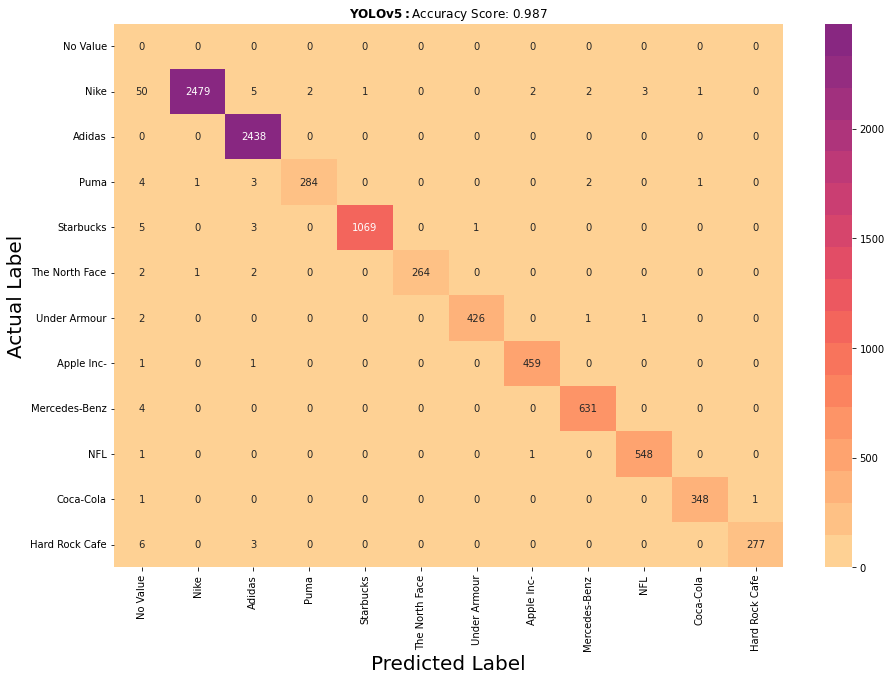

In [9]:
import seaborn as sns
c_matrix = confusion_matrix(data["true_cat"], data["pred_cat"])


df_cm = pd.DataFrame(c_matrix, names, names)
plt.figure(figsize=(15,10))
plt.title(r"$\bf{YOLOv5:}$Accuracy Score: 0.987")
palette = sns.color_palette(palette='magma', n_colors= 30)



sns.heatmap(df_cm, annot=True, fmt = 'd', cmap = palette[27:10:-1]) # font size
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('Actual Label', fontsize = 20)

plt.show()

In [10]:
print(classification_report(data["true_cat"], data["pred_cat"]))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      0.97      0.99      2545
           1       0.99      1.00      1.00      2438
           2       0.99      0.96      0.98       295
           3       1.00      0.99      1.00      1078
           4       1.00      0.98      0.99       269
           5       1.00      0.99      0.99       430
           6       0.99      1.00      0.99       461
           7       0.99      0.99      0.99       635
           8       0.99      1.00      0.99       550
           9       0.99      0.99      0.99       350
          10       1.00      0.97      0.98       286

    accuracy                           0.99      9337
   macro avg       0.91      0.90      0.91      9337
weighted avg       1.00      0.99      0.99      9337



/home/3054408/.conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/3054408/.conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/3054408/.conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predictions on Additional Test SET

In [11]:
def additional_test_details(path_true_label, path_pred, print_image = False, confidence = 0.05):
    """
    Compute dataset with all predictions
    """
    
    file_type = 'txt'
    name_files = []
    
    data = []
    
    for file in glob.iglob(path_true_label+'*.'+file_type):
        name_file = file.split("/")[-1].split('.'+file_type)[0]
        name_files.append(name_file)
    for item in name_files:
        with open(path_true_label + item +'.txt') as f:
            true_labels = f.readlines()
            if len(true_labels) > 0: #> 0
                for j in range(len(true_labels)):
                    true_sing = true_labels[j].split()
                    x_y_true = np.array(convert(true_sing))
                    try:
                        with open(path_pred + item +'.txt') as g:
                            preds = g.readlines()
                            for i in range(len(preds)):
                                pred_sing = preds[i].split()
                                x_y_pred = convert(pred_sing)
                                iou_pred = calculate_iou(x_y_true, np.array(x_y_pred))
                                    
                                true_label = true_sing[0]
                                pred_label = pred_sing[0]
                                _conf = float(pred_sing[-1])
                                true_bounding = convert(true_sing)
                                
                                new_row = item, true_label, pred_label, iou_pred, _conf, true_bounding, x_y_pred
                                data.append(new_row)
                    except:
                        true_label = true_sing[0]
                        true_bounding = convert(true_sing)
                    
                        new_row = item, true_label, -1, 0, 100, true_bounding, (0,0,0,0)
                        data.append(new_row)
                        
            if print_image== True and item in to_del:
                print(true_label, pred_label)
                image_specific =  pd.DataFrame(data, columns= ['picture','true_label','pred_label','list_iou','list_conf','true_bounding','pred_bounding'])
                image_specific = image_specific.loc[(image_specific.picture == item) & (image_specific.list_conf > confidence)].reset_index(drop = True)
                image = cv2.imread(path_image+item+'.jpg')
                color_true = (0, 255, 0) #green
                color_pred = (255, 0, 0) #red
                thickness = 3
                
                for i in range(image_specific.shape[0]):
                    x_y_true = image_specific.loc[i]['true_bounding']
                    x_y_pred = image_specific.loc[i]['pred_bounding']
                    start_point_true, end_point_true = (x_y_true[0], x_y_true[3]), (x_y_true[1], x_y_true[2])
                    start_point_pred, end_point_pred = (x_y_pred[0], x_y_pred[3]), (x_y_pred[1], x_y_pred[2])
                    
                    image = cv2.rectangle(image, start_point_true, end_point_true, color_true, thickness)
                    image = cv2.rectangle(image, start_point_pred, end_point_pred, color_pred, thickness)

                # Window name in which image is displayed
                plt.imshow(image)
                plt.show()
            
    data =  pd.DataFrame(data, columns= ['picture','true_label','pred_label','list_iou','list_conf','true_bounding','pred_bounding'])
    
    
    return data

In [12]:
exp = 'exp36'

path_image = "/home/3054408/yolov5/runs/detect/"+ exp +"/"
path_true_label = "/home/3054408/final_additional_test_augm/labels/"
path_pred = "/home/3054408/yolov5/runs/detect/"+exp+"/labels/"

In [13]:
all_combinations = additional_test_details(path_true_label , path_pred, print_image=False)

In [14]:
all_combinations

,picture,true_label,pred_label,list_iou,list_conf,true_bounding,pred_bounding
0,--------------------------adidas-soccer-----3-...,1,1,0.781699,0.315100,"(565, 591, 581, 606)","(564, 595, 582, 605)"
1,--------------------------adidas-soccer-----3-...,1,1,0.000000,0.328994,"(565, 591, 581, 606)","(418, 454, 251, 273)"
2,--------------------------adidas-soccer-----3-...,1,1,0.000000,0.315100,"(419, 453, 255, 273)","(564, 595, 582, 605)"
3,--------------------------adidas-soccer-----3-...,1,1,0.772727,0.328994,"(419, 453, 255, 273)","(418, 454, 251, 273)"
4,--------------------------adidas-soccer---_jpe...,1,1,0.838093,0.877269,"(303, 354, 289, 350)","(298, 356, 286, 350)"
...,...,...,...,...,...,...,...
1812,yanchama7_263505688_969322520600446_7459206072...,0,0,0.000000,0.668631,"(97, 250, 229, 296)","(358, 626, 251, 368)"
1813,yanchama7_263505688_969322520600446_7459206072...,0,9,0.000000,0.012913,"(361, 559, 252, 363)","(565, 626, 264, 311)"
1814,yanchama7_263505688_969322520600446_7459206072...,0,9,0.000000,0.334692,"(361, 559, 252, 363)","(28, 98, 240, 276)"
1815,yanchama7_263505688_969322520600446_7459206072...,0,0,0.700918,0.668631,"(361, 559, 252, 363)","(358, 626, 251, 368)"


In [57]:
predictions = all_combinations.loc[all_combinations.groupby(['picture','true_bounding'])['list_iou'].idxmax().values].reset_index(drop = True)

In [60]:
number_of_bad_prediction = all_combinations[all_combinations.list_conf > 0.08]
number_of_bad_prediction['is_bad'] = number_of_bad_prediction.pred_bounding.apply(lambda x: True if x not in set(predictions.pred_bounding.unique()) else False)
                                                                     
len(all_combinations[all_combinations.is_bad == True].pred_bounding.unique())/len(predictions.pred_bounding.unique())*100                                                                        

7.2727272727272725

In [61]:
predictions.loc[predictions.list_conf < 0.06, 'list_iou'] = 0

In [62]:
dict_names

{'0': 'Nike',
 '1': 'Adidas',
 '2': 'Puma',
 '3': 'Starbucks',
 '4': 'The North Face',
 '5': 'Under Armour',
 '6': 'Apple Inc-',
 '7': 'Mercedes-Benz',
 '8': 'NFL',
 '9': 'Coca-Cola',
 '10': 'Hard Rock Cafe'}

In [63]:
scores = pd.DataFrame(predictions.groupby('true_label')['list_iou'].mean()).reset_index()
scores['true_label_names'] = scores.true_label.apply(lambda x: dict_names[str(x)])
scores.true_label = scores.true_label.astype(np.int32)
scores = scores.sort_values(by = ['true_label_names'])

In [64]:
scores

,true_label,list_iou,true_label_names
1,1,0.846175,Adidas
7,6,0.762146,Apple Inc-
10,9,0.846489,Coca-Cola
2,10,0.883455,Hard Rock Cafe
8,7,0.798081,Mercedes-Benz
9,8,0.835715,NFL
0,0,0.750661,Nike
3,2,0.741698,Puma
4,3,0.879495,Starbucks
5,4,0.827014,The North Face


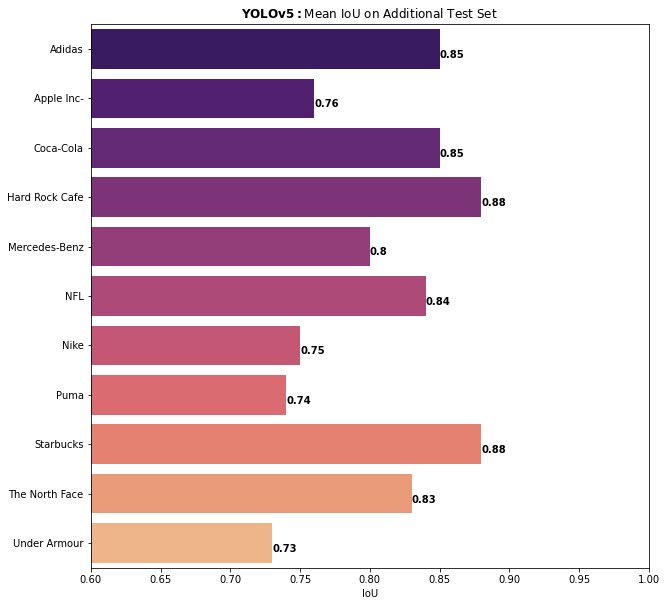

In [65]:
fig, axes = plt.subplots(1, 1, figsize=(10,10))

sns.barplot(x = np.round(scores['list_iou'],2), y = scores['true_label_names'], 
            palette = palette[5:30:2], ax = axes)
axes.set_xlim(0.6, 1)
#axes[1].axvline(x=0.80, c= 'red', lw = 3, )
#axes[1].axvline(x=0.85, c= 'red', lw = 3, )
axes.set_title(r"$\bf{YOLOv5:}$Mean IoU on Additional Test Set")
for i, v in enumerate(scores['list_iou']):
    axes.text(np.round(v,2), 0.18+i, round(v,2), color='black', fontweight='bold')
axes.set_xlabel('IoU')
axes.set_ylabel('')
plt.show()